In [1]:
# Sensor size: 8.712 x 6.588 mm
# Source: https://www.flir.com/products/blackfly-s-board-level/?model=BFS-U3-28S5C-BD2&vertical=machine+vision&segment=iis

# Mask size for 25% aperture (side-wise) and 6.25% aperture (area-wise)
# Real size with 4.5um pixel pitch size: 2.178 x 1.647 mm
# To_print mask size (1px=0.54um): (2.178*1000)/0.54 x (1.647*1000)/0.54 = 4033 x 3050 pixels
# To_print mask size (1px=2.16um): (2.178*1000)/2.16 x (1.647*1000)/2.16 = 1000 x 756 pixels

# Mask size for 50% aperture (side-wise) and 25% aperture (area-wise)
# Real size with 4.5um pixel pitch size: 4.356 x 3.294 mm
# To_print mask size (1px=0.54um): (4.356*1000)/0.54 x (3.294*1000)/0.54 = 8066 x 6100 pixels
# To_print mask size (1px=2.16um): (4.356*1000)/2.16 x (3.294*1000)/2.16 = 2000 x 1512 pixels

# Mask size for 65% aperture (side-wise) and 42% aperture (area-wise)
# Real size with 4.5um pixel pitch size: 5.663 x 4.279 mm
# To_print mask size (1px=0.54um): (5.663*1000)/0.54 x (4.279*1000)/0.54 = 10491 x 7913 pixels
# To_print mask size (1px=2.16um): (5.663*1000)/2.16 x (4.279*1000)/2.16 = 2600 x 1968 pixels

# Glass plate size: 40x40 mm
# Pixels needed to print on all glass plate area: (40*1000)/0.54 x (40*1000)/0.54 = 740000 x 74000 pixels
# Pixels needed to print on all glass plate area (1px=2.16um): (40*1000)/2.16 x (40*1000)/2.16 = 18500 x 18500 pixels

# Mask size for open aperture (full glass plate)
# Real size: 35 x 35 mm
# To_print mask size: (35*1000)/0.54 x (35*1000)/0.54 = 64815 x 64815 pixels

In [2]:
740000/4

185000.0

In [3]:
# (5.663 * 4.279) / (8.712 * 6.588)
# (5.663*1000)/0.54 , (4.279*1000)/0.54
(40*1000)/2

20000.0

# Vectorial implementation of the "create radial mask" procedure

In [4]:
import numpy as np
import torch
from math import cos, sin, radians
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.transforms.functional import to_tensor, to_pil_image, center_crop, pad

In [5]:
# mask_shape = (64000,64000)
# mask_shape = (1000,1000)

aperture = [25, 50, 65, 'open'][3]
precision = [0.54, 2, 2.16][0]

if precision == 0.54:
    if aperture == 25:
        mask_shape = (4200, 4200) # For 25% aperture
        real_mask_shape = (3050, 4033) # For 25% aperture
    elif aperture == 50:
        mask_shape = (8200, 8200) # For 50% aperture
        real_mask_shape = (6100, 8066)
    elif aperture == 65:
        mask_shape = (11000, 11000)
        real_mask_shape = (7900, 10500)
    elif aperture == 'open':
        # mask_shape = (65000, 65000)
        # real_mask_shape = (64815, 64815)
        mask_shape = (37000, 37000)
        real_mask_shape = (37000, 37000)
elif precision == 2:
    if aperture == 25:
        mask_shape = (1090, 1090)
        real_mask_shape = (824, 1090)
    elif aperture == 50:
        mask_shape = (2180, 2180)
        real_mask_shape = (1650, 2180)
    elif aperture == 65:
        mask_shape = (2840, 2840)
        real_mask_shape = (2140, 2840)
    elif aperture == 'open':
        mask_shape = (20000, 20000)
        real_mask_shape = (20000, 20000)
elif precision == 2.16:
    if aperture == 25:
        mask_shape = (1000, 1000)
        real_mask_shape = (756, 1000)
    elif aperture == 50:
        mask_shape = (2000, 2000)
        real_mask_shape = (1512, 2000)
    elif aperture == 65:
        mask_shape = (2600, 2600)
        real_mask_shape = (1968, 2600)
    elif aperture == 'open':
        mask_shape = (18500, 18500)
        real_mask_shape = (18500, 18500)


if precision == 0.54:
    # full_mask_shape = (74000, 74000)
    full_mask_shape = (37000, 37000)
elif precision == 2:
    full_mask_shape = (20000, 20000)
elif precision == 2.16:
    full_mask_shape = (18500, 18500)

n_rays = 70
angle_ray = 2.60

xc = mask_shape[0]//2
yc = mask_shape[1]//2

angle_center = 360.0 / n_rays
alphas = [((i*angle_center))%360 for i in range(0, n_rays)]

ray_side_height = mask_shape[0] + mask_shape[1]
# Describe rays as triangles (3 coordinate points that extend beyond the matrix elements)
triangles = []
for alpha in alphas:
    x1 = ray_side_height * cos(radians(alpha) + radians(angle_ray))
    y1 = ray_side_height * sin(radians(alpha) + radians(angle_ray))
    x2 = ray_side_height * cos(radians(alpha) - radians(angle_ray))
    y2 = ray_side_height * sin(radians(alpha) - radians(angle_ray))
    triangles.append([[0, 0], [x1, y1], [x2, y2]])

In [6]:
def generate_xy(x_i, x_f, y_i, y_f):

    # Create a grid of x, y coordinates within the specified range
    x_range = torch.arange(x_i, x_f)
    y_range = torch.arange(y_i, y_f)
    xx_range, yy_range = torch.meshgrid(x_range, y_range, indexing='xy')

    # Stack the coordinates to form pairs and reshape to the desired format
    positions_range = torch.stack((xx_range, yy_range), dim=2).reshape(-1, 2)
    return positions_range

# generate_xy(0, 1, 0, 100)


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# xy = xy.to(device)
t = torch.from_numpy(np.array(triangles)).to(device)

def check_inside_triangle(xy, t, n_rays=70, mini_mask_shape=(1000, 1000)):

    aux_a = ((xy[:, 0] - xc)[:, None] * t[:, 2, 1][None, :] - (xy[:, 1] - yc)[:, None] * t[:, 2, 0])
    aux_b = (t[:, 0, 0]*t[:, 2, 1] - t[:, 0, 1]*t[:, 2, 0])[None, :]
    aux_c = (t[:, 1, 0]*t[:, 2, 1] - t[:, 1, 1]*t[:, 2, 0])[None, :]
    a_vet = (aux_a - aux_b) / aux_c
    # a = ((xy[:, 0] - xc)[:, None] * t[:, 2, 1][None, :] - (xy[:, 1] - yc)[:, None] * t[:, 2, 0]) - (t[:, 0, 0]*t[:, 2, 1] - t[:, 0, 1]*t[:, 2, 0])[None, :] / (t[:, 1, 0]*t[:, 2, 1] - t[:, 1, 1]*t[:, 2, 0])[None, :]

    aux_a = ((xy[:, 0] - xc)[:, None] * t[:, 1, 1][None, :] - (xy[:, 1] - yc)[:, None] * t[:, 1, 0])
    aux_b = (t[:, 0, 0]*t[:, 1, 1] - t[:, 0, 1]*t[:, 1, 0])[None, :]
    aux_c = (t[:, 1, 0]*t[:, 2, 1] - t[:, 1, 1]*t[:, 2, 0])[None, :]
    b_vet = -(aux_a - aux_b) / aux_c
    
    aux_a = a_vet > 0
    aux_b = b_vet > 0
    aux_c = a_vet+b_vet < 1
    aux = aux_a & aux_b & aux_c
    # r_aux = aux.reshape(mask_shape[0], mask_shape[1], n_rays)
    # print(aux.shape, r_aux.shape)
    r_aux = aux.reshape(mini_mask_shape[0], mini_mask_shape[1], n_rays)

    return r_aux
# aa = is_inside_t = check_inside_triangle(xy, t)
# b = -(((xy[:, 0] - xc)[:, None] * t[:, 1, 1][None, :] - (xy[:, 1] - yc)[:, None] * t[:, 1, 0][None, :]) - (t[:, 0, 0]*t[:, 1, 1] - t[:, 0, 1]*t[:, 1, 0])[None, :]) / t[:, 1, 0]*t[:, 2, 1] - t[:, 1, 1]*t[:, 2, 0][None, :]

In [8]:
thetas = torch.load('temp_mask.pt')['pixel_val'].sigmoid().to(device)
mask = torch.zeros(mask_shape).reshape(1, -1) - 1.0
mask = mask.to(device)

n_line_splits = 10

for i in range(0, mask.squeeze().shape[0]-(mask_shape[1]//n_line_splits), mask_shape[1]//n_line_splits):
    # print(i*mask_shape[0]//n_line_splits)
    # xy[i*mask_shape[0]//n_line_splits:(i+1)*mask_shape[0]//n_line_splits]

    xy = generate_xy(x_i=i//mask_shape[0], x_f=(i//mask_shape[0])+1, y_i=i%mask_shape[0], y_f=(i%mask_shape[0])+(mask_shape[0]//n_line_splits))
    aux = check_inside_triangle(xy, t, n_rays=70, mini_mask_shape=(1, xy.shape[0], n_rays))
    aa = torch.zeros(xy.shape[0]) - 1.0
    aa = aa.unsqueeze(0).to(device)
    for k in range(n_rays-1, -1, -1):
        aa[(aa[0, :] == -1) & aux[..., k]] = thetas[k]
    mask[0, i:i + mask_shape[0]//n_line_splits] = aa[0, :]
mask[mask==-1] = 0.0

C:\Users\Vieira\AppData\Local\Temp\ipykernel_1608\4191279157.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thetas = torch.load('temp_mask.pt')['pixel_val'].sigmoid().t

In [9]:
cropper_mask = center_crop(mask.reshape(mask_shape), real_mask_shape)
cropper_mask.shape

torch.Size([37000, 37000])

In [10]:
# full_mask = pad(cropper_mask, ((74000-cropper_mask.shape[1])//2, (74000-cropper_mask.shape[0])//2), padding_mode='constant', fill=0.0)
# full_mask.shape

full_mask = pad(cropper_mask, ((full_mask_shape[1]-cropper_mask.shape[1])//2, (full_mask_shape[0]-cropper_mask.shape[0])//2), padding_mode='constant', fill=0.0)
full_mask.shape

torch.Size([37000, 37000])

In [18]:
full_mask.shape

torch.Size([37000, 37000])

In [19]:
for i in range(0, (full_mask.shape[0]//1792)+1):
    temp_mask = full_mask[i*1792:(i+1)*1792, :].clone()
    temp_mask = temp_mask.to('cpu')
    temp_mask = temp_mask.squeeze().numpy()
    temp_mask = temp_mask > 0.5
    temp_mask = Image.fromarray(temp_mask).convert('1')
    temp_mask.save(f'c:/Users/Vieira/Desktop/open_radial/{i}.bmp')

In [13]:
reshaped_mask = full_mask
for idx, i in enumerate(range(0, full_mask.shape[0] , 448)):
    m = reshaped_mask[i:i+448, :].cpu().numpy()
    sr_m = np.zeros_like(np.repeat(m, 4, axis=0))
    sr_m = np.repeat(sr_m, 4, axis=1)

    for i in range(0, m.shape[0]):
        for j in range(0, m.shape[1]):
            sr_m[i*4:(i+1)*4, j*4:(j+1)*4] = m[i, j]

    sr_m = sr_m > 0.5
    im = Image.fromarray((sr_m))
    im = im.convert('1')
    # im.save('/media/vieira/PortableSSD/NakamuraSensei/{}_OptRadial_{}.bmp'.format(aperture, idx))
    # im.save(f'g:\.shortcut-targets-by-id\1Yzvw4JTATQJcSBxTKDMzdTMsTdqWGF_j\Yagilab-CP\Vieira\open_radial_{idx}.bmp')
    im.save(f'c:/Users/Vieira/Desktop/open_radial/open_radial_{idx}.bmp')
    

KeyboardInterrupt: 

In [ ]:
# reshaped_mask = full_mask
# for idx, i in enumerate(range(0, full_mask.shape[0] , 1792)):
#     m = reshaped_mask[i:i+1792, :].cpu().numpy()
#     im = Image.fromarray((m*255).astype(np.uint8), 'L')
#     im.save('Data/to_print/{}_OptRadial_{}.bmp'.format(aperture, idx))
#     im.save('/media/vieira/PortableSSD/NakamuraSensei/{}_OptRadial_{}.bmp'.format(aperture, idx))

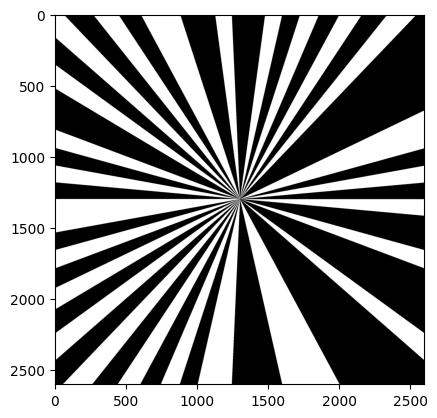

In [ ]:
plt.imshow(mask.reshape(mask_shape), cmap='gray')

In [ ]:
aa = a[1100:1200, 36950:36950+100]
aa.shape

(100, 100)

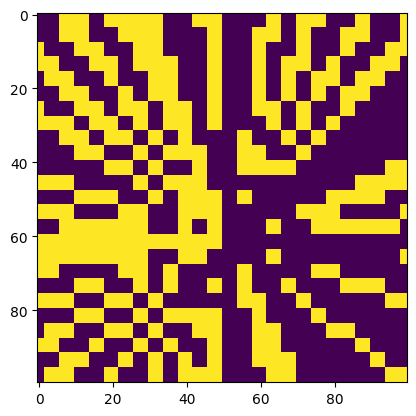

In [ ]:
aaa = aa.copy()
# aaa[]
plt.imshow(aa)

/home/vieira/anaconda3/envs/blindps/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (132608000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


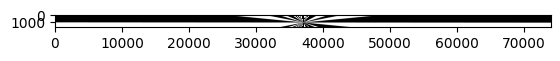

In [ ]:
a = np.array(Image.open('/media/vieira/PortableSSD/NakamuraSensei/aperture_open/open_OptRadial_20.bmp'))
plt.imshow(a, cmap='gray')